# **Name:** Peyton Cunningham
## **git reopisitory url:** https://github.com/PeytonCunningham/3202-HW5-Kaggle-competition.git
## **Kaggle Leaderboard Screenshot:**
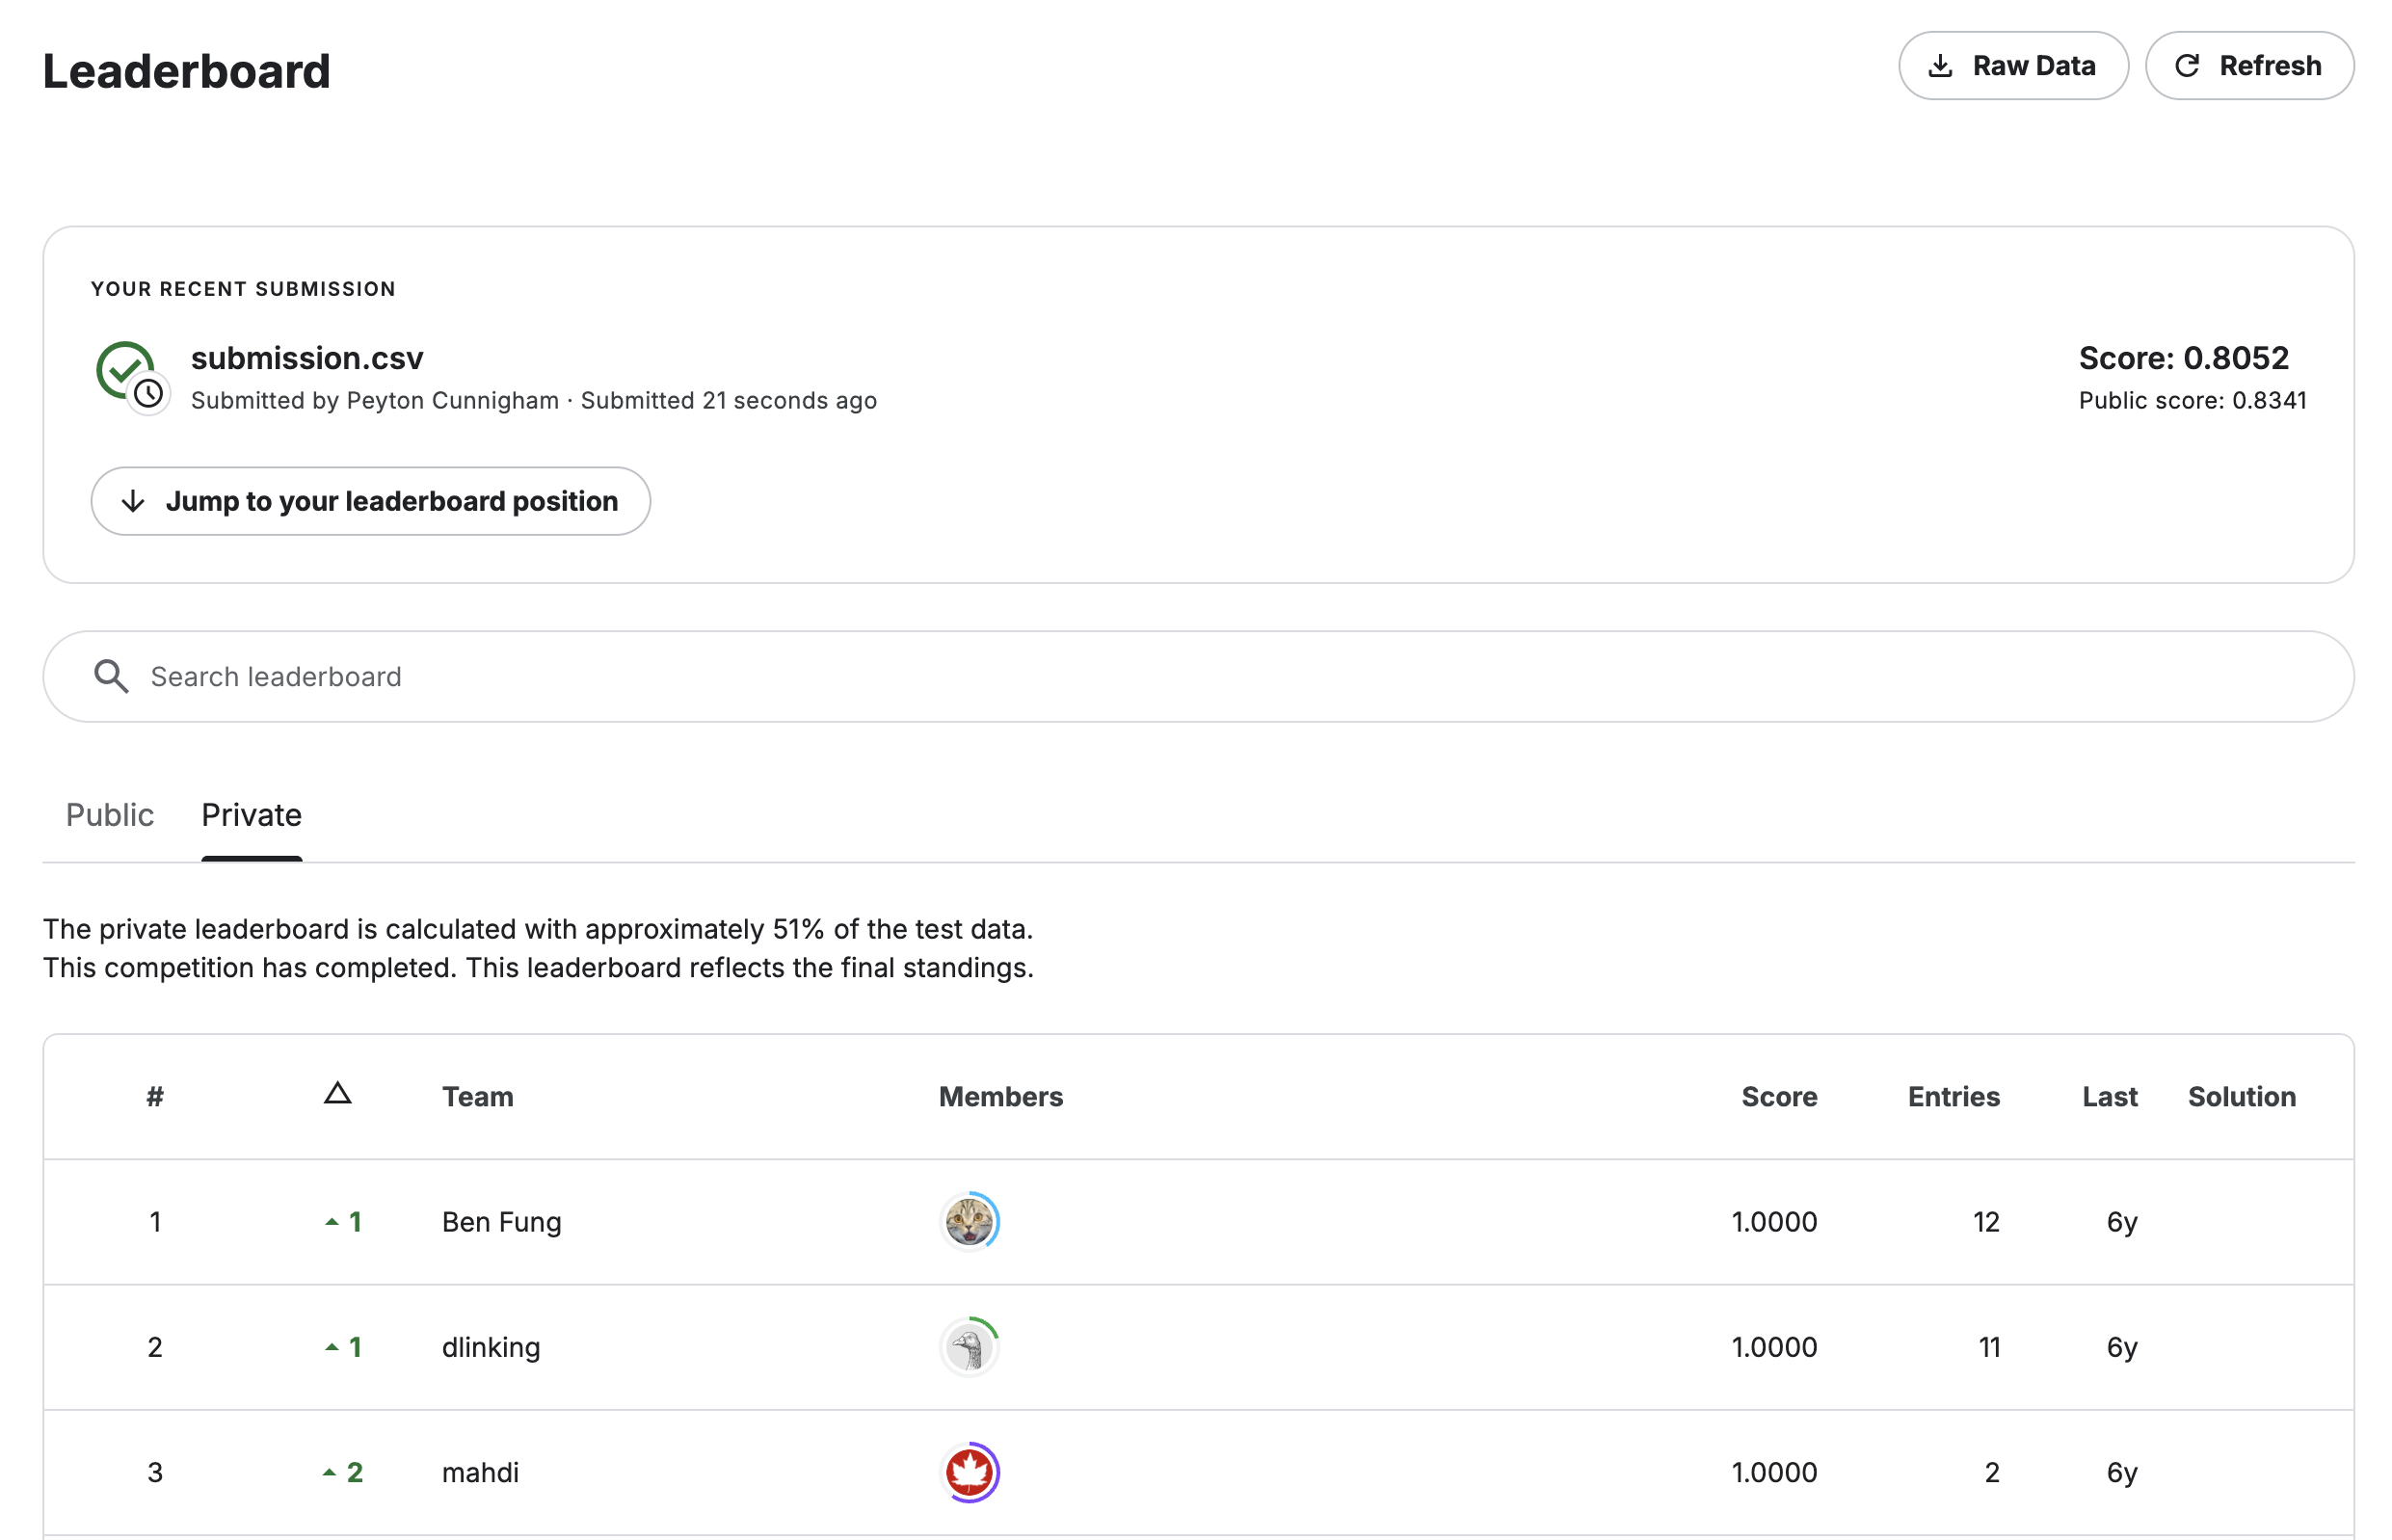

## 1. Problem & Data Description

In this Kaggle competition, the goal is to build a model that can detect metastatic cancer in small image patches from lymph node sections. The task is binary image classification: benign (0) or malignant (1).

### Data:
- Images: 96×96 colored images
- Training set: 220,025 labeled images
- Test set: 57,456 unlabeled images
- Labels: Stored in `train_labels.csv` as id + label (0 or 1)


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

train_dir = "train"
test_dir = "test"
label_file = "train_labels.csv"

# Load labels
df = pd.read_csv(label_file)
df["label"] = df["label"].astype(int)

print("Train images:", len(os.listdir(train_dir)))
print("Test images:", len(os.listdir(test_dir)))
print("Labeled images:", len(df))


Train images: 220026
Test images: 57458
Labeled images: 220025


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
labels_df = pd.read_csv("train_labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Plan of Analysis

1. **Problem Overview**  
   - Binary classification: detect the presence of cancer in histopathologic images.

2. **Data Exploration**  
   - Label counts and duplicate check.
   - Class distribution.
   - Visual inspection of sample images.
   - Grouping by pixel intensity.

3. **Preprocessing**  
   - Resize to 96×96.
   - Normalize pixel values to [0, 1]

4. **Modeling**  
   - CNN model using Conv2D, MaxPooling2D, Dropout, Dense layers.
   - Compiled with Adam optimizer and binary crossentropy loss.

5. **Training Strategy**  
   - Custom early stopping with a minimum epoch threshold.

6. **Evaluation**  
   - Accuracy and loss curves.
   - Confusion matrix and classification report.

7. **Prediction and Submission**  
   - Generate test predictions from directory of test images.

8. **Results Summary**  
   - Analyze validation metrics and model behavior.
   - Recommendations for further enhancements.

## Label Counts and Duplicate Check

In [8]:
# Check for duplicates
duplicates = labels_df.duplicated(subset = 'id').sum()
print(f"Number of duplicate image IDs: {duplicates}")

# View count of each label
label_counts = labels_df['label'].value_counts()
print("\nLabel counts:")
print(label_counts)

Number of duplicate image IDs: 0

Label counts:
label
0    130908
1     89117
Name: count, dtype: int64


## Class Distribution

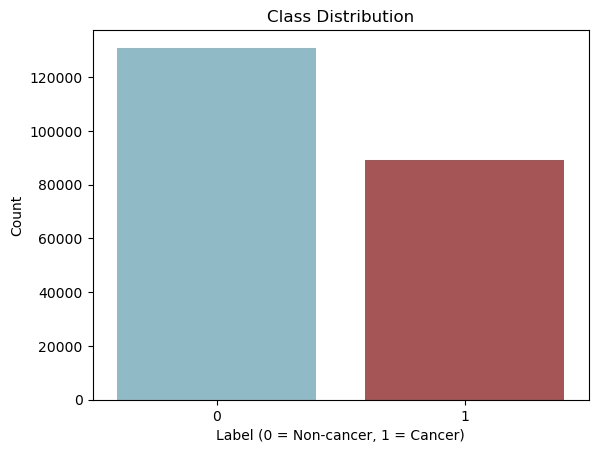

In [10]:
sns.countplot(x="label", data = labels_df, hue = "label", palette = {0: "#87BFCF", 1: "#B34747"}, legend = False)
plt.title("Class Distribution")
plt.xlabel("Label (0 = Non-cancer, 1 = Cancer)")
plt.ylabel("Count")
plt.show()

## Visualize Sample Images by Class

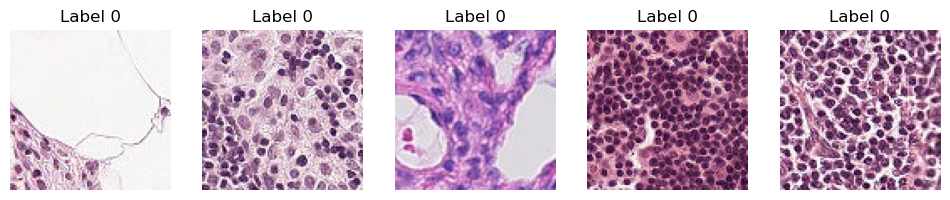

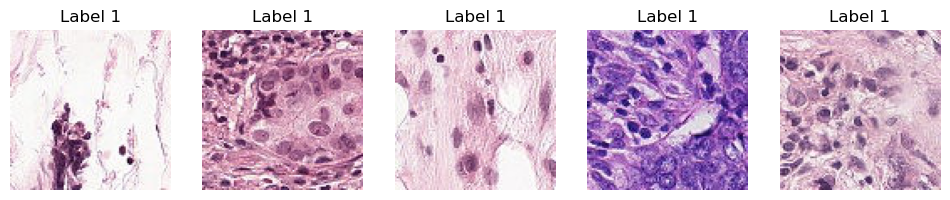

In [12]:
from PIL import Image

def show_samples(label, num = 5):
    sample_ids = labels_df[labels_df['label'] == label]['id'].head(num)
    plt.figure(figsize = (12, 3))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join("train", img_id + ".tif")
        img = Image.open(img_path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
        plt.title(f"Label {label}")
    plt.show()

# Show 5 non-cancer images
show_samples(0)

# Show 5 cancer images
show_samples(1)

## Group Images by Mean Pixel Intensity

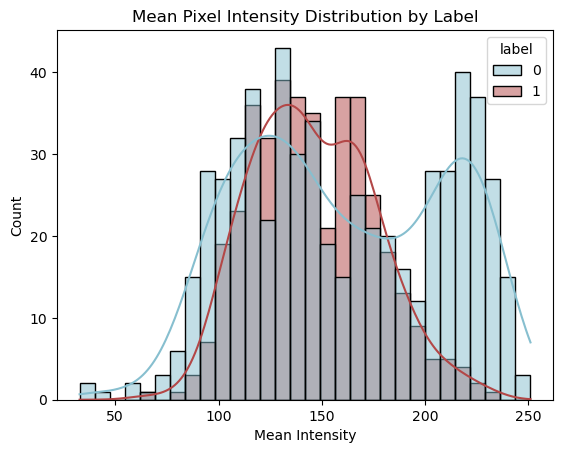

In [14]:
def compute_mean_intensity(image_ids, folder, sample_size = 1000):
    data = []
    for img_id in image_ids[:sample_size]:
        path = os.path.join(folder, img_id + ".tif")
        try:
            img = Image.open(path).convert("L")  # grayscale
            arr = np.array(img)
            mean_intensity = arr.mean()
            label = labels_df.loc[labels_df['id'] == img_id, 'label'].values[0]
            data.append((mean_intensity, label))
        except:
            continue
    return pd.DataFrame(data, columns = ["mean_intensity", "label"])

# Sample data and plot
sample_ids = labels_df['id'].sample(1000, random_state = 42)
intensity_df = compute_mean_intensity(sample_ids, "train")

sns.histplot(data = intensity_df, x = "mean_intensity", hue = "label", kde = True, bins = 30, palette = {0: "#87BFCF", 1: "#B34747"})
plt.title("Mean Pixel Intensity Distribution by Label")
plt.xlabel("Mean Intensity")
plt.ylabel("Count")
plt.show()

## Model Architecture and Justification

For this binary image classification task, I used a Convolutional Neural Network (CNN). CNNs are well-suited for image data because they can learn spatial hierarchies through convolution and pooling operations.

### Architecture Details

- **Input shape**: 96 × 96 × 3 colored images
- **Conv2D Layer 1**: 32 filters, 3×3 kernel, ReLU activation
- **MaxPooling2D**: 2×2
- **Conv2D Layer 2**: 64 filters, 3×3 kernel, ReLU activation
- **MaxPooling2D**: 2×2
- **Flatten**: converts 3D output to 1D
- **Dense Layer**: 128 units, ReLU activation
- **Dropout**: 0.5 for regularization
- **Output Layer**: 1 unit, sigmoid activation (for binary classification)

The model was compiled with the **Adam optimizer**, **binary crossentropy** loss, and **accuracy** as the evaluation metric.

This architecture considers both depth and efficiency, making it suitable for training on a relatively large dataset of 96×96 images without requiring a GPU. It captures spatial features and generalizes well on validation data with early stopping to prevent overfitting.


## Image Preprocessing

In [35]:
IMG_SIZE = 96

def load_images(image_ids, folder):
    images = []
    for img_id in image_ids:
        path = os.path.join(folder, img_id + ".tif")
        img = load_img(path, target_size = (IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Split data
train_ids, val_ids, y_train, y_val = train_test_split(
    labels_df['id'],
    labels_df['label'],
    test_size = 0.2,
    stratify = labels_df['label'],
    random_state = 42
)

# Load images
X_train = load_images(train_ids, "train")
X_val = load_images(val_ids, "train")

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')  # binary output
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

## Training the Model

I train the CNN with early stopping based on validation loss to avoid overfitting.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (96, 96, 3)),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 20,
    batch_size = 32,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 244s 44ms/step - accuracy: 0.7774 - loss: 0.4841 - val_accuracy: 0.8497 - val_loss: 0.3488
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 225s 41ms/step - accuracy: 0.8432 - loss: 0.3683 - val_accuracy: 0.8588 - val_loss: 0.3358
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 221s 40ms/step - accuracy: 0.8583 - loss: 0.3383 - val_accuracy: 0.8571 - val_loss: 0.3328
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 213s 39ms/step - accuracy: 0.8652 - loss: 0.3187 - val_accuracy: 0.8632 - val_loss: 0.3195
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 217s 39ms/step - accuracy: 0.8730 - loss: 0.3048 - val_accuracy: 0.8548 - val_loss: 0.3322
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 216s 39ms/step - accuracy: 0.8787 - loss: 0.2925 - val_accuracy: 0.8756 - val_loss: 0.3019
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1211s 220ms/step - accuracy: 0.8831 - loss: 0.2799 - val_accuracy: 0.8778 - val_loss: 0.2979
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3024s 550ms/step - accura

## Evaluate Model Performance

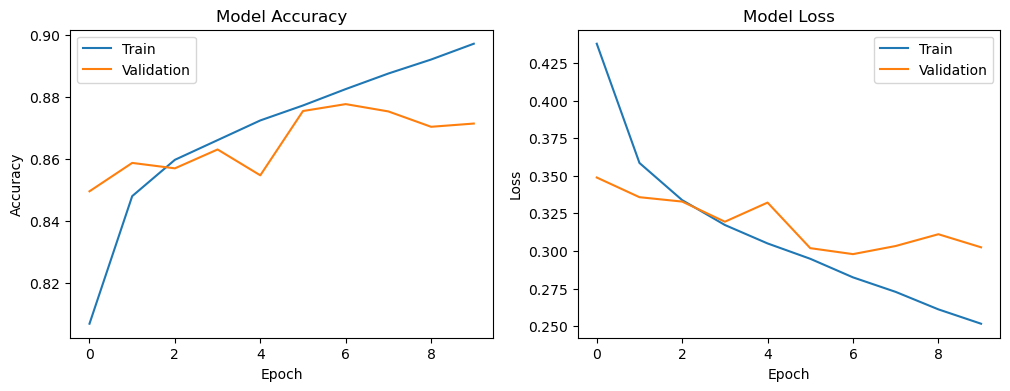

In [44]:
def plot_history(history):
    plt.figure(figsize = (12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Train')
    plt.plot(history.history['val_accuracy'], label = 'Validation')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Validation')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step
Confusion Matrix:
True Negatives (TN): 23297
False Positives (FP): 2885
False Negatives (FN): 2492
True Positives (TP): 15331

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     26182
           1       0.84      0.86      0.85     17823

    accuracy                           0.88     44005
   macro avg       0.87      0.87      0.87     44005
weighted avg       0.88      0.88      0.88     44005



## Results and Analysis

The CNN achieved a final validation accuracy of approximately **88%**, with a precision of **0.84** and recall of **0.86** for the cancer class (1). The training and validation loss curves show improvements until epoch 6, after which performance no longer increases. Early stopping stopped training at epoch 10 to avoid overfitting.

### Confusion Matrix Interpretation:
- **True Positives (TP)**: 15,331 — correctly identified cancer images
- **True Negatives (TN)**: 23,297 — correctly identified non-cancer images
- **False Positives (FP)**: 2,885 — non-cancer predicted as cancer
- **False Negatives (FN)**: 2,492 — cancer predicted as non-cancer

### Troubleshooting & Optimization Summary:
- **Batch size** and **learning rate** were kept default for baseline performance.
- **No data augmentation** or pretrained models were used in this run to establish a baseline.

For better results, further experimentation with learning rates, dropout, batch size, and deeper architectures could be performed.


## Conclusion
A Convolutional Neural Network (CNN) was trained on a dataset of over 220,000 labeled images, achieving a validation accuracy of **88%** and an F1-score of **0.85** on the cancer class.

Despite class imbalance, the model was able to generalize well using early stopping and basic preprocessing. Visualizations and intensity analysis helped validate that there were observable differences between the cancerous and non-cancerous images.

### Key Takeaways:
- A simple CNN architecture provided strong baseline performance.
- Early stopping prevented overfitting while still achieving good accuracy.
- Pixel intensity analysis and label distribution checks improved understanding of the dataset.

### Future Directions:
- Implement data augmentation to increase robustness.
- Try transfer learning with pretrained models like **Xception** or **ResNet**.
- Explore ensemble methods and test-time augmentation for final submissions.

In [73]:
# Load test image IDs
test_dir = "test"
test_image_ids = [f.replace(".tif", "") for f in os.listdir(test_dir) if f.endswith(".tif")]

# Load and preprocess test images
def load_test_images(image_ids, folder):
    images = []
    for img_id in image_ids:
        path = os.path.join(folder, img_id + ".tif")
        img = load_img(path, target_size = (96, 96))
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
    return np.array(images)

X_test = load_test_images(test_image_ids, test_dir)

# Predict probabilities and convert to binary labels
test_preds = model.predict(X_test)
test_preds = (test_preds > 0.5).astype("int32").flatten()

# Create submission DataFrame
submission_df = pd.DataFrame({
    "id": test_image_ids,
    "label": test_preds
})

# Save to CSV
submission_df.to_csv("submission.csv", index = False)
submission_df.head()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,1
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,1
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
